<a href="https://colab.research.google.com/github/lofel888/ML_code_projects/blob/main/U_net_DZ5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

U net


Saving pone.0229448.g004.jpg to pone.0229448.g004.jpg


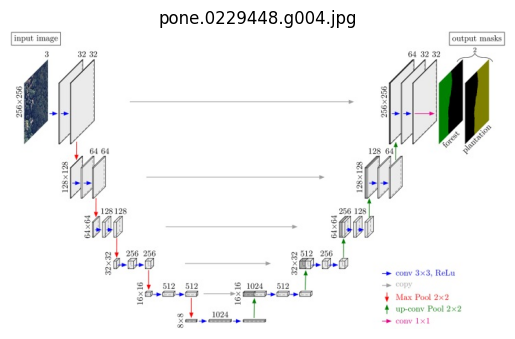

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import PIL.Image

# Загружаем файл
uploaded = files.upload()

# Открываем и показываем первое изображение
for filename in uploaded.keys():
    img = PIL.Image.open(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)
    plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Выравнивание размеров
        dh = skip.size(2) - x.size(2)
        dw = skip.size(3) - x.size(3)
        x = nn.functional.pad(x, [dw // 2, dw - dw // 2, dh // 2, dh - dh // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Encoder(64, 128)
        self.down2 = Encoder(128, 256)
        self.down3 = Encoder(256, 512)
        self.down4 = Encoder(512, 1024)
        self.up1 = Decoder(1024, 512)
        self.up2 = Decoder(512, 256)
        self.up3 = Decoder(256, 128)
        self.up4 = Decoder(128, 64)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [ ]:
def get_transforms():
    # Преобразования для изображений и масок
    def image_transform(image):
        return transforms.Compose([
            transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])(image)

    def mask_transform(mask):
        # Маска: 1 — питомец, 2 — фон, 3 — контур.
        mask = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)(mask)
        mask = torch.from_numpy(np.array(mask)).long()
        mask = mask - 1  # теперь метки: 0, 1, 2
        return mask

    return image_transform, mask_transform

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, split="train", image_transform=None, mask_transform=None):
        self.dataset = datasets.OxfordIIITPet(
            root=root, split=split, target_types='segmentation', download=True
        )
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    for images, masks in tqdm(dataloader, desc="Validation"):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, mask_true = dataset[idx]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img)
    pred_mask = pred.argmax(dim=1).cpu().squeeze()

    img_np = img.cpu().squeeze().permute(1, 2, 0).numpy()
    # Обратная нормализация
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Изображение")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Реальная Маска")
    plt.imshow(mask_true, cmap="tab10")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Предсказанная Маска")
    plt.imshow(pred_mask, cmap="tab10")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == "__main__":
    import numpy as np

    ROOT = "./data"
    BATCH_SIZE = 8
    NUM_EPOCHS = 50
    LR = 1e-4
    NUM_CLASSES = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_tf, mask_tf = get_transforms()

    train_ds = SegmentationDataset(ROOT, split="trainval", image_transform=img_tf, mask_transform=mask_tf)
    test_ds = SegmentationDataset(ROOT, split="test", image_transform=img_tf, mask_transform=mask_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = UNet(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    # Обучение
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_loss = validate(model, test_loader, criterion, DEVICE)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    visualize_prediction(model, test_ds, DEVICE, idx=5)


Epoch 1/50


Training:   2%|▏         | 11/460 [00:05<04:04,  1.83it/s]


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 792M/792M [00:47<00:00, 16.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.5MB/s]


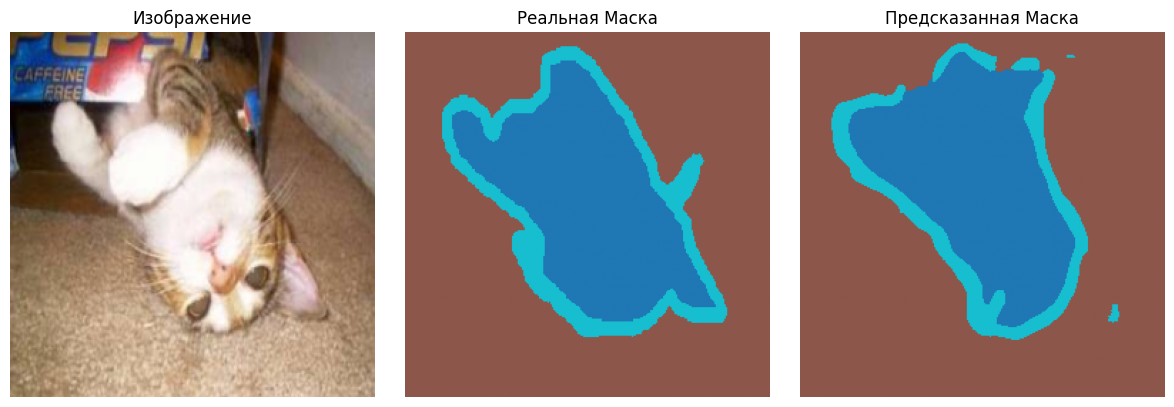

In [ ]:
from google.colab import drive
import torch
import numpy as np
drive.mount('/content/drive')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT = "./data"
img_tf, mask_tf = get_transforms()
test_ds = SegmentationDataset(ROOT, split="test", image_transform=img_tf, mask_transform=mask_tf)
model = UNet(in_channels=3, num_classes=3).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/unet_pets.pth', map_location=DEVICE))
model.eval()

visualize_prediction(model, test_ds, DEVICE, idx=10)

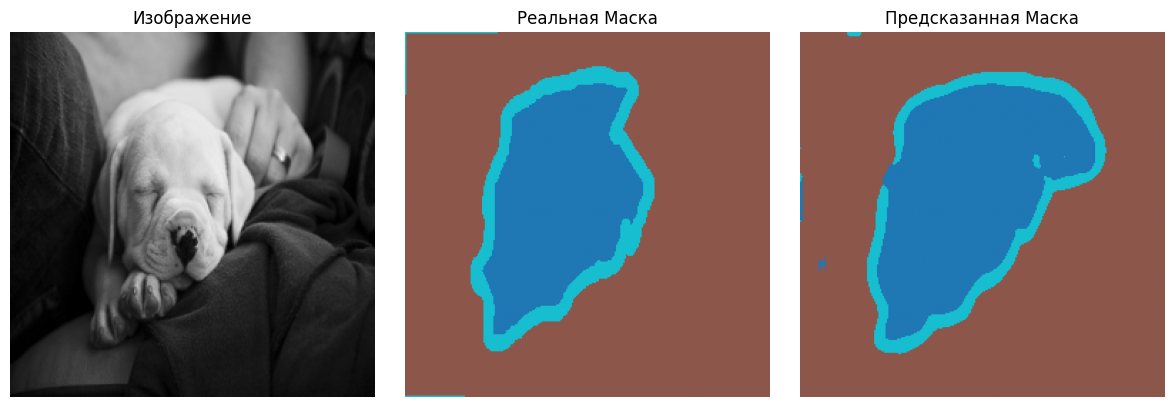

In [ ]:
visualize_prediction(model, test_ds, DEVICE, idx=100)

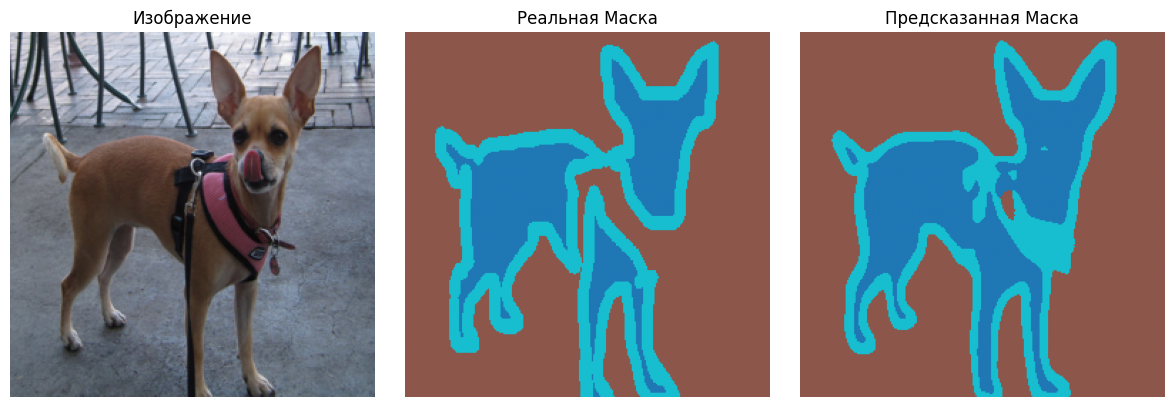

In [ ]:
visualize_prediction(model, test_ds, DEVICE, idx=1000)